In [1]:
import os

from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file

#Set your SERPER_API_KEY for goolge search tool and OPENAI_API_KEY in .env for openai api.

#os.environ["SERPER_API_KEY"] = "90fd35ce9e1f8434d5060c0fed4013d09b1496f7"

import warnings
warnings.filterwarnings("ignore")


#from langchain_visualizer.jupyter import visualize
#import asyncio
#The visualizer is for tracing the prompt messages in detail and debug. 

In [2]:
# used for vpn setting. 
#os.environ['http_proxy'] = "http://127.0.0.1:7890" 
#os.environ['https_proxy'] = "https://127.0.0.1:7890" 
#import requests
#requests.get("https://google.com")

<Response [200]>

In [3]:
import json
import pandas as pd
#import pinecone
import re
from tqdm.auto import tqdm
from typing import List, Union
import zipfile

In [4]:
from langchain.chat_models import ChatOpenAI
from langchain import OpenAI, LLMChain

from langchain.prompts import BaseChatPromptTemplate, ChatPromptTemplate

from langchain.memory import ConversationBufferMemory
from langchain.memory import ConversationSummaryMemory, ChatMessageHistory

from langchain.agents import ZeroShotAgent, Tool, AgentExecutor
from langchain.agents import load_tools, initialize_agent
from langchain.agents import AgentType

from langchain.tools import HumanInputRun
from langchain.agents import Tool, AgentExecutor, LLMSingleActionAgent, AgentOutputParser
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.schema import AgentAction, AgentFinish, HumanMessage, SystemMessage
from langchain.vectorstores import Pinecone

from langchain.utilities import GoogleSerperAPIWrapper
from langchain.tools.python.tool import PythonREPLTool

In [5]:
llm = ChatOpenAI(temperature=0)
# create necessary tools
python_repl = PythonREPLTool()
search = GoogleSerperAPIWrapper()
human = HumanInputRun()
# You can create the tool to pass to an agent
repl_tool = Tool(
    name="python_repl",
    description="A Python shell. Use this to execute python commands. Input should be a valid python command. If you want to see the output of a value, you should print it out with `print(...)`.",
    func=python_repl.run
)
google_serp = Tool(
        name="search",
        func=search.run,
        description="Useful for when you need to ask with search"
    )
human_tool = Tool(
        name="human",
        func=human.run,
        description="useful for when you need to ask for human guidance. Use this tool more often if the question is about data or type of chart."
    )

In [6]:
# Changing the description of tools can influence the agent's priority of using them
#tools = load_tools(["human", "python_repl"], llm=llm)
tools = [
    human_tool,repl_tool, google_serp
]
#tools[0].description = tools[0].description + "Always use this tool first. Show your thought to human first, and then ask questions about specific information. "
#tools.append(google_serp)
#tools[1].description = tools[1].description + "If modules or libraries is missing, ask human for help with instructions. Use fake data if no data input is provided."
#tools[2].description = tools[2].description + "Must include python in the searching keyword."
#print(type(tools[2]))

In [31]:
#Create the prompt. It is hard to get exactly what I want with the instruction in prompt. Still work in process.       
template = """ You are an assistant that only helps with visualization tasks, such as producing figure or chart for certain data.
Have a conversation with human, and finish all intermediate goals that are related to the questions. 

You have access to the following tools:
{tools}

Use the following format:
Question: the input question you must answer
Intermediate Goals: the intermediate steps you must finish in order before you answer the questions.
Thought: you should always think about what to do.
Action: the action to take, should be one of [{tool_names}].
Action Input: the input to the action. 
Observation: the result of the action
... (this Thought/Action/Action Input/Observation can repeat N times)
Thought: I now know the final answer
Final Answer: the final answer to the original input question. Must provide a python code template, as well as the result of executing the code.

Begin! Remember to give detailed, informative answers.

Previous conversation history:
{history}

New question: {input}
Intermediate Goals: {intermediate}
{agent_scratchpad}"""

intermediate = ["1.Ask human the data you need to use.", "2.Print out the columns of data file in python to learn what information you have.", "2.Ask human the type of chart you need to plot with python.","3.Provide a python code that produce the chart.",
                "4.Fix all bugs in the code.", "5.Ask for human opinion, and iterate until human is satisfied."]
# Set up a prompt template
class CustomPromptTemplate(BaseChatPromptTemplate):
    # The template to use
    template: str
    # The list of tools available
    tools: List[Tool]
    intermediate: List[str]
    def format_messages(self, **kwargs) -> str:
        # Get the intermediate steps (AgentAction, Observation tuples)
        
        # Format them in a particular way
        intermediate_steps = kwargs.pop("intermediate_steps")
        thoughts = ""
        for action, observation in intermediate_steps:
            thoughts += action.log
            thoughts += f"\nObservation: {observation}\nThought: "
        # Set the agent_scratchpad variable to that value
        kwargs["agent_scratchpad"] = thoughts
        
        # Create a tools variable from the list of tools provided
        kwargs["tools"] = "\n".join([f"{tool.name}: {tool.description}" for tool in self.tools])
        
        # Create a list of tool names for the tools provided
        kwargs["tool_names"] = ", ".join([tool.name for tool in self.tools])
        kwargs["intermediate"]="\n ".join([steps for steps in self.intermediate])
        formatted = self.template.format(**kwargs)
        return [HumanMessage(content=formatted)]


    
prompt = CustomPromptTemplate(
    template=template,
    tools=tools,
    intermediate = intermediate,
    # This omits the `agent_scratchpad`, `tools`, and `tool_names` variables because those are generated dynamically
    # This includes the `intermediate_steps` variable because that is needed
    input_variables=["input", "intermediate_steps", "history"]
)


In [32]:
class CustomOutputParser(AgentOutputParser):
    
    def parse(self, llm_output: str) -> Union[AgentAction, AgentFinish]:
        
        # Check if agent should finish
        if "Final Answer:" in llm_output:
            return AgentFinish(
                # Return values is generally always a dictionary with a single `output` key
                # It is not recommended to try anything else at the moment :)
                return_values={"output": llm_output.split("Final Answer:")[-1].strip()},
                log=llm_output,
            )
        
        # Parse out the action and action input
        regex = r"Action: (.*?)[\n]*Action Input:[\s]*(.*)"
        match = re.search(regex, llm_output, re.DOTALL)
        
        # If it can't parse the output it raises an error
        # You can add your own logic here to handle errors in a different way i.e. pass to a human, give a canned response
        if not match:
            raise ValueError(f"Could not parse LLM output: `{llm_output}`")
        action = match.group(1).strip()
        action_input = match.group(2)
        
        # Return the action and action input
        return AgentAction(tool=action, tool_input=action_input.strip(" ").strip('"'), log=llm_output)
    
output_parser = CustomOutputParser()

In [33]:
llm_chain = LLMChain(llm=OpenAI(temperature=0), prompt=prompt)
tool_names = [tool.name for tool in tools]
agent = LLMSingleActionAgent(
    llm_chain=llm_chain, 
    output_parser=output_parser,
    stop=["\nObservation:"], 
    allowed_tools=tool_names
)
memory = ConversationBufferMemory(memory_key="history")
#memory = ConversationBufferWindowMemory(k=2)
#memory = ConversationSummaryMemory(llm=OpenAI(temperature=0))
agent_executor = AgentExecutor.from_agent_and_tools(agent=agent, tools=tools, verbose=True, memory=memory)




> Entering new  chain...
Thought: I need to ask human for the data and type of chart.
Action: human
Action Input: What data do I need to use to create a chart for population distribution in America?

What data do I need to use to create a chart for population distribution in America?
use ./population.csv


Observation:use ./population.csv
 I need to print out the columns of data file in python to learn what information I have.
Action: python_repl
Action Input: print(pd.read_csv('./population.csv').columns)

Observation:Index(['STATE', 'POPESTIMATE2019', 'lat', 'long'], dtype='object')

 I need to ask human the type of chart I need to plot with python.
Action: human
Action Input: What type of chart should I use to plot population distribution in America?

What type of chart should I use to plot population distribution in America?
use a pie chart


Observation:use a pie chart
 I need to provide a python code that produce the chart.
Action: python_repl
Action Input: 
import pandas as pd

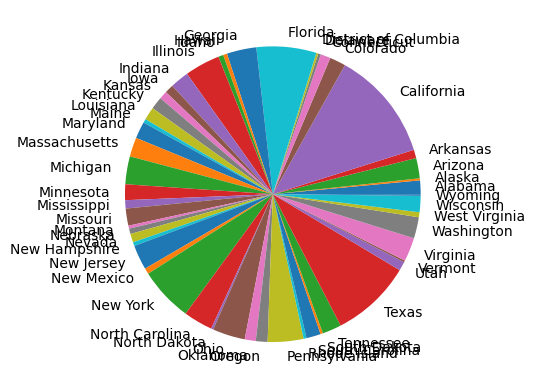



Observation:
 I need to fix all bugs in the code.
Action: python_repl
Action Input: 
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('./population.csv')

plt.pie(df['POPESTIMATE2019'], labels=df['STATE'], autopct='%1.1f%%')
plt.show()

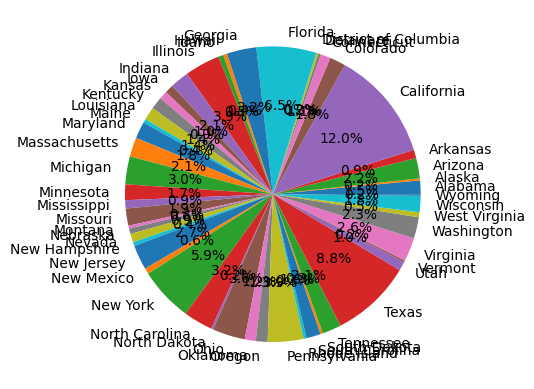



Observation:
 I need to ask for human opinion, and iterate until human is satisfied.
Action: human
Action Input: How does this chart look?

How does this chart look?
The figure looks crowded. Maybe it is better to show population on America map


Observation:The figure looks crowded. Maybe it is better to show population on America map
 I need to provide a python code that produce the chart.
Action: python_repl
Action Input: 
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd

df = pd.read_csv('./population.csv')

# read the shapefile
gdf = gpd.read_file('./states.shp')

# merge the geodataframe with the population dataframe
merged = gdf.merge(df, left_on='STATE', right_on='STATE')

# create the figure and axes
fig, ax = plt.subplots(figsize=(20, 10))

# plot the figure
merged.plot(column='POPESTIMATE2019', cmap='Blues', ax=ax, legend=True)

# add title
ax.set_title('Population Distribution in America', fontdict={'fontsize': 20})

# remove the axis
ax.set_axi

In [ ]:
agent_executor.run(
       # "Can you help me name a cat?"
       "Can you help me create a chart for population distribution in America?"
    )

#Use the following code to debug with visualize. 

#async def search_agent_demo():
#    return agent_chain.run(
#       "Can you help me visualize the population in America?"
#    )

#visualize(search_agent_demo)



> Entering new  chain...
Thought: I need to ask human for the data and type of chart, then use python to produce the chart.
Action: human
Action Input: What data do I need to use and what type of chart do I need to plot?

What data do I need to use and what type of chart do I need to plot?


KeyboardInterrupt: Interrupted by user